# Coordinated Spiking Model

Install required packages

In [4]:
import numpy as np
import pylab as pl
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d

## Single-neuron

Initialize parameters

In [218]:
# timesteps
dt = 0.01
iterations = 800
t = np.arange(0, iterations) * dt

# input estimate
x_est = np.zeros(iterations)

# spike train
o = np.zeros(iterations)

# voltage
voltage = np.zeros(iterations)

# ''output kernel''
weight = 2

# threshold
T = (weight**2) / 2

# spike times
spike = []
t_spike = []

Create time varying signal

In [219]:
# create time-varying signal
x = 5
x_t = np.ones(iterations) * x

step = 100
x_t[0:step] = 0
x_t[iterations - 2 * step:iterations] = 3

smooth = gaussian_filter1d(x_t, sigma=20) # smooth signal

dxdt = np.diff(smooth)/dt
c = smooth[:-1] + dxdt

Run simulation

In [220]:
for t in range(1, iterations):
    
    # udpate input estimate
    dxestdt = -x_est[t - 1] + weight * o[t - 1]
    x_est[t] = x_est[t - 1] + dt * dxestdt 
    
    # update voltage
    dVdt = -voltage[t - 1] + weight * c[t - 1] - o[t - 1] * (weight ** 2)
    voltage[t] = voltage[t - 1] + dt * dVdt
    
    # spike when voltage exceeds threshold
    if voltage[t] > T:
        o[t] = 1/dt
        
        # save spike times
        spike.append(1)
        t_spike.append(t)
      

Plot results (input + input estimate, voltage, spikes)

Text(0.5,0,'time')

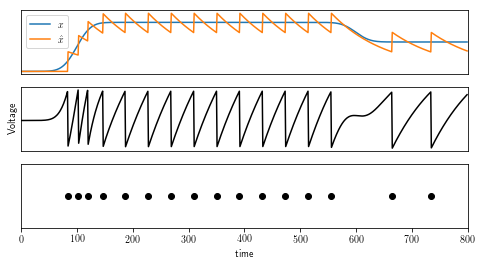

In [221]:
plots = 3
pl.subplots(plots, 1, figsize=(8, 4))

# enable LaTeX
pl.rc('text', usetex=True)

pl.subplot(plots, 1, 1)
pl.plot(smooth, label=r'$x$')
pl.plot(x_est, label=r'$\hat{x}$')
pl.xlim(0, iterations)
pl.yticks([])
pl.xticks([])
pl.legend()

pl.subplot(plots, 1, 2)
pl.plot(voltage, 'k')
pl.xlim(0, iterations)
pl.ylabel('Voltage')
pl.yticks([])
pl.xticks([])

pl.subplot(plots, 1, 3)
pl.scatter(t_spike, spike, c='k')
pl.xlim(0, iterations)
pl.yticks([])
pl.xlabel('time')

## $\textit{N}$-neurons

Network size

In [290]:
N = 7

Initialize parameters

In [300]:
# timesteps
dt = 0.01
iterations = 800
t = np.arange(0, iterations) * dt

# input estimate
x_est = np.zeros(iterations)

# spike trains
o = np.zeros((N, iterations))

# voltages
voltage = np.zeros((N, iterations))

# ''output kernel''
gamma = 2
weight = np.ones((1, N)) * gamma

# threshold
T = (gamma**2) / 2

Create time varying signal

In [301]:
# create time-varying signal
x = 5
x_t = np.ones(iterations) * x

step = 150
x_t[0:step] = 0
x_t[iterations - 2 * step:iterations] = 3

smooth = gaussian_filter1d(x_t, sigma=20) # smooth signal

dxdt = np.diff(smooth)/dt
c = smooth[:-1] + dxdt

In [302]:
for t in range(1, iterations):
    
    # update input estimate
    dxestdt = -x_est[t - 1] + np.dot(weight, o[:, t - 1])
    x_est[t] = x_est[t - 1] + dt * dxestdt 
    
    # update voltages
    dVdt = -voltage[:, t - 1] + weight * c[t - 1] - np.dot((weight ** 2), o[:, t - 1])
    voltage[:, t] = voltage[:, t - 1] + dt * dVdt
    
    above_threshold = np.where(voltage[:, t] > T)
    
    # reset neuron when threshold is exceeded
    if len(above_threshold[0]) > 0:
              
        # select random neuron who's voltage is above threshold
        spike_neuron = np.random.randint(0, len(above_threshold[0]))
        
        # update spikes
        o[spike_neuron, t] = 1/dt

Plot results

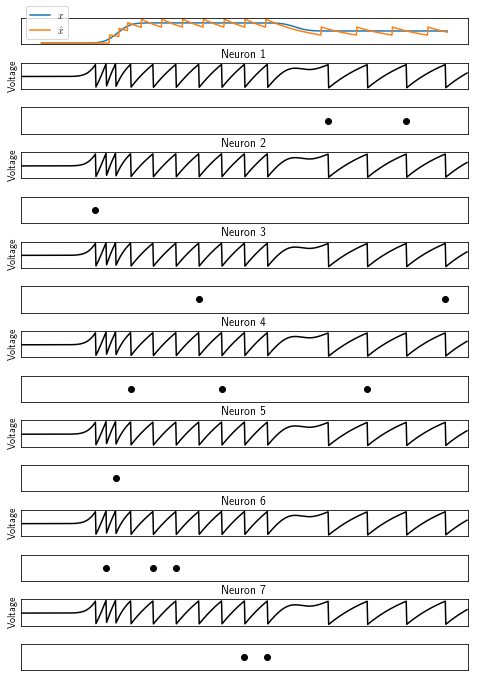

In [303]:
plots = (2 * N) + 1
pl.subplots(plots, 1, figsize=(8, 12))
pl.subplots_adjust(hspace=0.7)

# enable LaTeX
pl.rc('text', usetex=True)

counter = 2

pl.subplot(plots, 1, 1)
pl.plot(smooth, label=r'$x$')
pl.plot(x_est, label=r'$\hat{x}$')
pl.yticks([])
pl.xticks([])
pl.legend()

for i in range(N):
    
    neuron = i + 1
    
    pl.subplot(plots, 1, counter)
    pl.plot(voltage[i], 'k')
    pl.xlim(0, iterations)
    pl.ylabel('Voltage')
    pl.title('Neuron %i' %neuron)
    pl.yticks([])
    pl.xticks([])
    
    counter = counter + 1
    
    # extract spike times
    spike = []
    t_spike = []
    
    for s in range(1, iterations):
        if o[i, s] > 0:
            spike.append(1)
            t_spike.append(s)
    
    # plot spike times
    pl.subplot(plots, 1, counter)
    pl.scatter(t_spike, spike, c='k')
    pl.xlim(0, iterations)
    pl.yticks([])
    pl.xticks([])
    
    counter = counter + 1